# Generating Sentences One Letter at a Time
In this script we will create several character based language models using very simple conditional probability distributions (CPDs) by calculating histograms from the data (these are simple generative models that we will sample sentences from). We will also build basic logistic regression classfiers over bag of character and/or bag of word features (these are simple discriminative models that we will use to identify authors).  

## Generative Part
In the main part of the script, we will use **Markov Models** that remember either 0, 1, 2, 3 or 4 previous characters and emit a probability distrubiton over the next character in the sequence.  
Markov Models are perhaps the simplest and most streight forward way to model temporal sequences of discrete symbols (in our case, we will use characters as our discrete symbols).  

We will first see how discriminative these generative models can be for the task of author identification (spoiler: dispite their simplicity they are surprisingly good).  

We then continue to generate text in the style of the authors using those models to see what they have learned (another spoiler: they learn quite a bit, but not quite at the "famous author" level yet).   

In the end we will create a submission using our best markov model for the use of everyone who wishes to tweak it.

## Discriminative Part

In the very last part of the script, we employ a fully discriminative approach that is either character based or word based bag of word features:
1. Extract **Bag of Character n-grams** features
1. Create a submission for **Logistic Regression over *BagOfChar***
1. Extract **Bag of Word n-grams** features
1. Create a submission for **Logistic Regression over *BagOfWord***
1. Create a submission for **Logistic Regression over both *BagOfWord and BagOfChar***


**Note: ** I use only pandas, numpy and native python here to make it simpler to "get into" the code for those of you who wish to do so (only in the last discriminative part I use sklearn as well)

![nice animation](https://cdn-images-1.medium.com/max/1600/1*MbHRwYNA8F29hzes8EPHiQ.gif)

Check out this [blog post](https://hackernoon.com/from-what-is-a-markov-model-to-here-is-how-markov-models-work-1ac5f4629b71) from which I stole this nice animation above. It explains the basics of markov models and even contains code to apply markov models at the word level as basic discrete symbols. In this script, however, we will use characters as the basic discrete symbols. 

# Short Math Introduction
In this script we try to model the distribution of sentences $$P(Sentence)$$  
A sentence is just a sequence of $n$ characters and therrefore we can write $$P(Sentence) = P(c_1,c_2,c_3,...,c_n)$$  

**In this script** we will model this sequence of characters using short term memory conditional distributions.  
* **no memory** (this is also known as naive bayes): 
$$P(c_1,c_2,c_3,...,c_n) = P(c_1)P(c_2)P(c_3)...P(c_n) = \prod_{t=1}^{n}P(c_t)$$ 
* **1 time step memory** (this is the classical markov chain): 
$$P(c_1,c_2,c_3,...,c_n) = P(c_1)P(c_2|c_1)P(c_3|c_2)...P(c_n|c_{n-1}) = P(c_1)\prod_{t=2}^{n}P(c_t|c_{t-1})$$ 
* **2 time step memory**: 
$$P(c_1,c_2,c_3,...,c_n) = P(c_1)P(c_2|c_1)\prod_{t=3}^{n}P(c_t|c_{t-1},c_{t-2})$$ 
* **3 time step memory**: 
$$P(c_1,c_2,c_3,...,c_n) = P(c_1)P(c_2|c_1)P(c_3|c_2,c_1)\prod_{t=4}^{n}P(c_t|c_{t-1},c_{t-2},c_{t-3})$$ 
* **4 time step memory**: 
$$P(c_1,c_2,c_3,...,c_n) = P(c_1)P(c_2|c_1)P(c_3|c_2,c_1)P(c_4|c_3,c_2,c_1)\prod_{t=5}^{n}P(c_t|c_{t-1},c_{t-2},c_{t-3},c_{t-4})$$ 

## Note: 
In this corpus, the authors use 34 total characters (regular characters plus punctuation marks).  
What this means is that:  
Storing the $P(c_t)$ distribution will involve storing $34$ numbers.  
Storing the $P(c_t|c_{t-1})$ distribution will involve storing $34^2 = 1,156$ numbers.  
Storing the $P(c_t|c_{t-1},c_{t-2})$ distribution will involve storing $34^3 = 39,304$ numbers.  
Storing the $P(c_t|c_{t-1},c_{t-2},c_{t-3})$ distribution will involve storing $34^4 = 1,336,336$ numbers.  
Storing the $P(c_t|c_{t-1},c_{t-2},c_{t-3},c_{t-4})$ distribution will involve storing $34^5 = 45,435,424$ numbers.  

Keep in mind also that the entire corpus of this competition contains about ~3M characters so that we should start encountering substantial finite sample size effects for 3 and 4 history conditional probability distributions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn import model_selection, preprocessing, linear_model
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

matplotlib.style.use('fivethirtyeight')

## Load training data and seperate it into a train and validation sets

In [2]:
#%% load and organize data
data = pd.read_csv('../input/train.csv')

stratifiedCV = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=1)
trainInds, validInds = next(stratifiedCV.split(data['text'], data['author']))

trainText  = data.loc[trainInds,'text'].reset_index(drop=True)
validText  = data.loc[validInds,'text'].reset_index(drop=True)
trainLabel = data.loc[trainInds,'author'].reset_index(drop=True)
validLabel = data.loc[validInds,'author'].reset_index(drop=True)

## Collect all chars into one large string for each author

In [3]:
#%% some utility code
# dictionary to manually converts greek/spanish chars into closest english chars
toEnglishDict = {}
srcStr = ['à','â','ä','å','æ','ç','è','é','ê','ë','ï','î','ñ','ô','ö','õ','ü','û','α','δ','ν','ο','π','ς','υ','ἶ']
dstStr = ['a','a','a','a','a','c','e','e','e','e','i','i','n','o','o','o','u','u','a','d','n','o','p','s','y','i']
for src,dst in zip(srcStr,dstStr):
    toEnglishDict[src] = dst
    
# function that converts all non english chars to their closest english char counterparts
def myunidecode(inString):
    outString = ''
    for ch in inString:
        if ch in toEnglishDict.keys():
            outString += toEnglishDict[ch]
        else:
            outString += ch
    return outString

In [4]:
#%% go over all train data and collect one large char sequence for each author
charsDict = {}
for key in ['all','EAP','HPL','MWS']:
    charsDict[key] = []

for k, (sentence, author) in enumerate(zip(trainText,trainLabel)):
    # the decoding is done for spanish/greek chars to be converted to close english chars
    decodedSentence = myunidecode(sentence.lower())
    chars = [char for char in decodedSentence]
    
    charsDict['all']  += chars
    charsDict[author] += chars

# Show the Char usage Distribution for each Author
$$P(c_t|Author)$$

In [5]:
#%% show char usage histogram for the three authors
charEncoder = preprocessing.LabelEncoder()
charEncoder.fit(charsDict['all'])

charCounts_EAP = np.histogram(charEncoder.transform(charsDict['EAP']),range(len(charEncoder.classes_)+1),density=True)[0]
charCounts_HPL = np.histogram(charEncoder.transform(charsDict['HPL']),range(len(charEncoder.classes_)+1),density=True)[0]
charCounts_MWS = np.histogram(charEncoder.transform(charsDict['MWS']),range(len(charEncoder.classes_)+1),density=True)[0]

# sort the char classes by their usage frequency
sortedChars = np.flipud(np.argsort(charCounts_EAP + charCounts_HPL + charCounts_MWS))

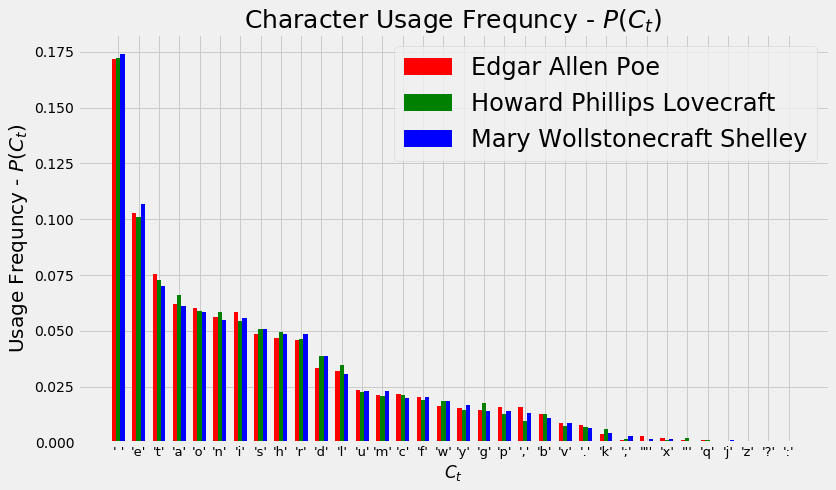

In [6]:
barWidth = 0.21
x = np.arange(len(charCounts_EAP))

plt.figure(figsize=(12,7)); plt.title('Character Usage Frequncy - $P(C_t)$ ',fontsize=25);
plt.bar(x-barWidth, charCounts_EAP[sortedChars], barWidth, color='r', label='Edgar Allen Poe');
plt.bar(x         , charCounts_HPL[sortedChars], barWidth, color='g', label='Howard Phillips Lovecraft');
plt.bar(x+barWidth, charCounts_MWS[sortedChars], barWidth, color='b', label='Mary Wollstonecraft Shelley');
plt.legend(fontsize=24); plt.ylabel('Usage Frequncy - $P(C_t)$', fontsize=20); plt.xlabel('$C_t$');
plt.xticks(x,["'%s'" %(charEncoder.classes_[i]) for i in sortedChars], fontsize=13);

Interestingly, there are differences between the authors here!  
## Lets look at the same plot only with log scale on the y axis

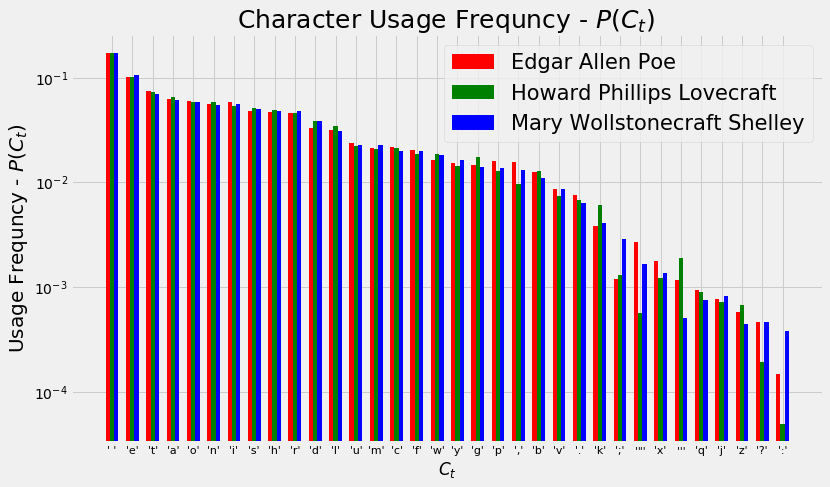

In [7]:
barWidth = 0.21
x = np.arange(len(charCounts_EAP))

plt.figure(figsize=(12,7)); 
plt.title('Character Usage Frequncy - $P(C_t)$ ',fontsize=25);
plt.bar(x-barWidth, charCounts_EAP[sortedChars], barWidth, color='r', label='Edgar Allen Poe');
plt.bar(x         , charCounts_HPL[sortedChars], barWidth, color='g', label='Howard Phillips Lovecraft');
plt.bar(x+barWidth, charCounts_MWS[sortedChars], barWidth, color='b', label='Mary Wollstonecraft Shelley');
plt.legend(fontsize=21); plt.ylabel('Usage Frequncy - $P(C_t)$', fontsize=20); 
plt.yscale("log", nonposy='clip'); plt.xlabel('$C_t$');
plt.xticks(x,["'%s'" %(charEncoder.classes_[i]) for i in sortedChars], fontsize=11);

Very large differences can be seen in usage of punctuation marks.  
For example, the ":" character is used much more extensivley by MWS and least used by HPL.

Even though these differences look small, they are extreemly statistically significant since there are about 2,600,000 chars in the training set. These differences are not there by chance, and perhaps we can utilize these differences for classification. Lets try.

# How do we Identify the Author of each Sentence using our CPDs?
In this competition specifically, we would like to model the conditional probability distribution of the author given a sentence: $$P(Author | Sentence) = P(Author | c_1,c_2,c_3,...,c_n)$$  

We have three different authors here, so this boils down to:  

$$P(EAP | c_1,c_2,c_3,...,c_n)$$    
$$P(HPC | c_1,c_2,c_3,...,c_n)$$    
$$P(MWS | c_1,c_2,c_3,...,c_n)$$  

Using the bayes rule we can invert this into $$P(Author | Sentence) = \frac{P(Sentence | Author)P(Author)}{P(Sentence)}$$  
The prior distribution $P(Author)$ over authors is extreemly simple to calcualte (it's just the frequency of occurence of each author in the training set).  

For any specific sentence, the probability of that sentence $P(Sentence)$ is identical for all authors and therefore doesn't create any additional discrimination between them, so when creating a classifier we can just ignore this and compare the 3 following quantities:  

$$P(c_1,c_2,c_3,...,c_n | EAP)P(EAP)$$    
$$P(c_1,c_2,c_3,...,c_n | HPC)P(HPC)$$    
$$P(c_1,c_2,c_3,...,c_n | MWS)P(MWS)$$  
meaning:
$$  \mathbf{predicted\:Author} = argmax\:\{{P(c_1,c_2,c_3,...,c_n|Author)P(Author)}\}   $$

# Calculate Classification Accuracy based only on single char distribution
$$  \mathbf{predicted\:Author} = argmax\:\{ \prod_{t=1}^{n}P(c_t|Author)\}   $$  

**Note:** we assume here an equal prior just for simplicity (i.e. $P(Author) = \frac{1}{3}$ for all authors)  


In [8]:
#%% meassure classification accuracy on validation set using only character frequncy
authorsList = ['EAP','HPL','MWS']
authorPredictionList = []
for k, (sentence, author) in enumerate(zip(validText,validLabel)):
    chars = [char for char in myunidecode(sentence.lower())]
    # convert to log so we can sum probabilities instead of multiply
    logP_EAP = sum([np.log(charCounts_EAP[charEncoder.classes_ == ch]) for ch in chars])
    logP_HPL = sum([np.log(charCounts_HPL[charEncoder.classes_ == ch]) for ch in chars])
    logP_MWS = sum([np.log(charCounts_MWS[charEncoder.classes_ == ch]) for ch in chars])
    
    authorPredictionList.append(authorsList[np.argmax(np.array([logP_EAP,logP_HPL,logP_MWS]))])

print(52*'-')
print('==> Validation Set Classification Accuracy = %.1f%s' %(100*(validLabel == authorPredictionList).mean(),'%'))
print(52*'-')

----------------------------------------------------
==> Validation Set Classification Accuracy = 53.0%
----------------------------------------------------


Interestingly, even though this is perhaps the stupidest model one can think of, the discrimination accuracy is well above chance level.

## Generate Sample Text for each author using the independent chars model
$$  c_t \: {\raise.17ex\hbox{$\scriptstyle\mathtt{\sim}$}} \: P(c_t|Author)   $$

In [9]:
#%% generate sample text by sampling one charachter at a time for the independent character model
np.random.seed(1234)

maxSentenceLength = 95
numSentencesPerAuthor = 5

charProbModel = {}
charProbModel['all'] = (charCounts_EAP + charCounts_HPL + charCounts_MWS)/3.0
charProbModel['EAP'] = charCounts_EAP
charProbModel['HPL'] = charCounts_HPL
charProbModel['MWS'] = charCounts_MWS

for author in ['EAP','HPL','MWS','all']:
    print((6+maxSentenceLength)*'-')
    print('Author %s:' %(author))
    print(12*'-')
    for i in range(numSentencesPerAuthor):
        generatedSentence = ''
        for j in range(maxSentenceLength):
            newChar = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=charProbModel[author])][0]
            generatedSentence += newChar
            
            if (newChar == '.') or (j == maxSentenceLength):
                break
                
        print('%d: "%s"' %(i+1,generatedSentence))
print((4+maxSentenceLength)*'-')

-----------------------------------------------------------------------------------------------------
Author EAP:
------------
1: "."
2: "mfrrbcrvtehnoeih rtem etnerditfr ooatft , nli idh li mtryvrcmh."
3: "e fw  olh atei dfmtmo osnf iiuhhis nroriv  l ud."
4: "gttae,tootrlc en  dlsc" y,di twi eo ibwna rrptniaoutysiftwledtaoerromhsof eohen  o el ruwtmtoo "
5: "fce phnmefehxe ttemeaae npteceste   l c m sdpi in,rmimnarsoohsneie ksun e "i"ihtotcaotxndlsm cy"
-----------------------------------------------------------------------------------------------------
Author HPL:
------------
1: "ekia hyeo,   cirtnsloit r    hez dyetiutr viata owif lvwt."
2: "mee tn trdsh ffasolhhblpbi otiy, gtshtadoo clte hodstrbuuotahruntn seuh v n  nwope aq h,miisuao"
3: "oatiideewank ia t wde  em w,phrd go nelabts ntoh  s it nh   a e ttr."
4: "ltw donmsoe qe ot ,ee  f st afwr tse   t enlee eorat ta dsseaic mi pyreeeflm,to s n ae frnii ly"
5: "alsrdevaa hbi egroa ae hstay er fesoe oeskutg  dllh toes  ht i   tf nh

Well, as expected, we can see that this really doesn't resemble any human generated text.  
But perhaps we can do better with some memory?

## Gather DataFrame with "Author", "History" and "Next Char" Fields
Use history of 1 character 

In [10]:
#%% gather all pairs of characters into a single dataframe
historyLength = 1

historyList  = []
nextCharList = []
authorList   = []
for k, (sentence, author) in enumerate(zip(trainText,trainLabel)):
    decodedSentence = myunidecode(sentence.lower())
    charSequences = [decodedSentence[k:k+historyLength+1] for k in range(len(decodedSentence)-historyLength)]
    
    history  = [seq[:-1] for seq in charSequences]
    nextChar = [seq[ -1] for seq in charSequences]
    sentenceDF = pd.DataFrame(columns=['author','history','next char'])
    
    historyList  += history
    nextCharList += nextChar
    authorList   += [author]*len(history)
        
corpusDF = pd.DataFrame(columns=['author','history','next char'])
corpusDF['author']    = authorList
corpusDF['history']   = historyList
corpusDF['next char'] = nextCharList

corpusDF.head(8)

,author,history,next char
0,EAP,t,h
1,EAP,h,e
2,EAP,e,
3,EAP,,w
4,EAP,w,e
5,EAP,e,a
6,EAP,a,t
7,EAP,t,h


## Build Markov Model that Remebers only the previous char
$$P(c_t|c_{t-1},Author)$$

In [11]:
#%% generate P(c(t)|c(t-1)) model (Markov Model with memory of 1 time step)
charCondProbModel_H1 = {}
for author in ['EAP','HPL','MWS']:
    charCondProbModel_H1[author] = np.zeros( (1+historyLength)*[charEncoder.classes_.shape[0]] )
    
charCondCountModel_H1 = {}
for author in ['EAP','HPL','MWS']:
    charCondCountModel_H1[author] = np.zeros( (1+historyLength)*[charEncoder.classes_.shape[0]] )

corpusGroupedByAuthor = corpusDF.groupby(by='author',axis=0)
for author in corpusDF['author'].unique():
    authorCorpusDF = corpusGroupedByAuthor.get_group(author).loc[:,['history','next char']].reset_index(drop=True)
    authorCorpusGroupedByHistory = authorCorpusDF.groupby(by='history',axis=0)
    for history in authorCorpusDF['history'].unique():
        authorHistoryDF = authorCorpusGroupedByHistory.get_group(history).reset_index(drop=True).loc[:,'next char'].reset_index(drop=True)

        encodedHistory = charEncoder.transform([history])[0]
        encodedNextCharCounts = np.histogram(charEncoder.transform(authorHistoryDF),range(len(charEncoder.classes_)+1),density=False)[0]
        encodedNextCharProb   = np.histogram(charEncoder.transform(authorHistoryDF),range(len(charEncoder.classes_)+1),density=True)[0]

        charCondProbModel_H1[author][encodedHistory,:]  = encodedNextCharProb
        charCondCountModel_H1[author][encodedHistory,:] = encodedNextCharCounts

    condCount = charCondCountModel_H1[author]
    print('%s Sparsity level = %.1f%s' %(author, 100*(condCount < 1).sum() / (condCount > -1).sum().astype(float),'%'))

charCondProbModel_H1['all']  = (charCondProbModel_H1['EAP']  + charCondProbModel_H1['HPL']  + charCondProbModel_H1['MWS'] )/3.0
charCondCountModel_H1['all'] =  charCondCountModel_H1['EAP'] + charCondCountModel_H1['HPL'] + charCondCountModel_H1['MWS']

print('average Sparsity level = %.1f%s' %(100*(charCondCountModel_H1['all'] < 1).sum() / (condCount > -1).sum().astype(float),'%'))

EAP Sparsity level = 30.4%
MWS Sparsity level = 38.6%
HPL Sparsity level = 33.9%
average Sparsity level = 25.1%


# Show the Conditional Probability Distribution of the entire corpus 
$$P(c_t|c_{t-1}) $$

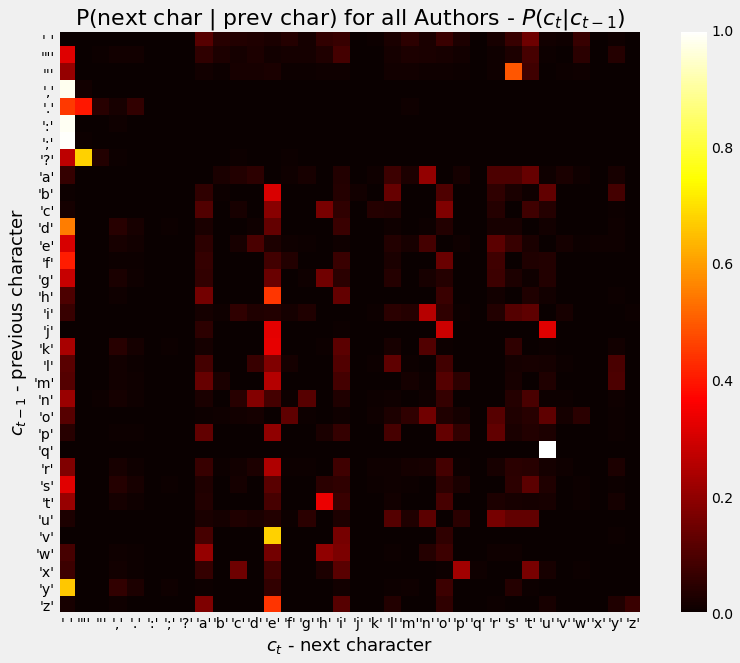

In [12]:
condProb = charCondProbModel_H1['all']

plt.figure(figsize=(12,10))
plt.imshow(condProb, cmap='hot');  plt.colorbar(); plt.clim(0,1);
plt.grid('off'); plt.title('P(next char | prev char) for all Authors - $P(c_t|c_{t-1})$', fontsize=22);
plt.xlabel('$c_t$ - next character', fontsize=18); plt.ylabel('$c_{t-1}$ - previous character', fontsize=18);
plt.xticks(range(condProb.shape[0]),["'%s'" %(ch) for ch in charEncoder.classes_]);
plt.yticks(range(condProb.shape[0]),["'%s'" %(ch) for ch in charEncoder.classes_]);

There are a few clear "columns" in the dataset - for the "a","e","i" and "o" characters (which are vowels, by the way). What this means is that these characters are quite likely to come after many other characters. Contrast that with "y" that is likely to occur mostly after "l", "m" and "b" (to form the pairs "ly", "my" and "by").

Note that we now have about 25% of character pairs that never occur in the training set at all. Even though we only have ~1,150 possible charachter pairs and ~2,600,000 pairs.  
In this particular case, it's safe to assume that the pairs that don't occur are simply very rare or non existent in the languge, but it's important to keep in mind that some of these zeros are perhaps due to finite sample size. This can be quanitfied of course, but we will skip this in this tutorial.

# Show the Author Specific Conditional Probability Distributions 
$$P(c_t|c_{t-1},Author) $$

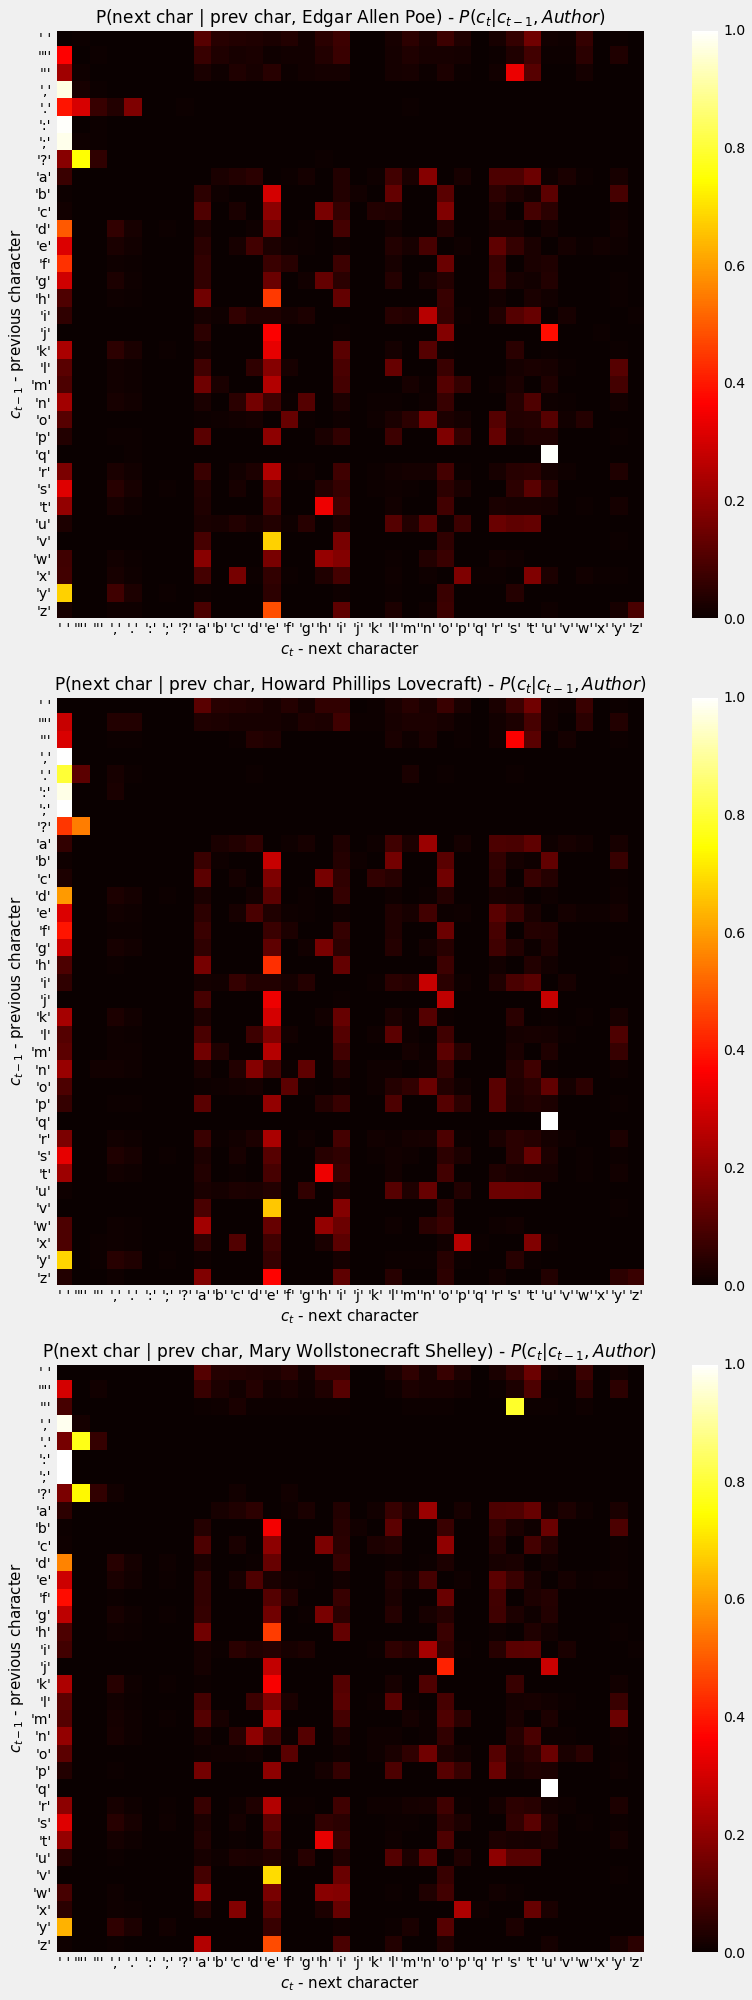

In [13]:
shortToFullNameDict = {}
shortToFullNameDict['EAP'] = 'Edgar Allen Poe'
shortToFullNameDict['HPL'] = 'Howard Phillips Lovecraft'
shortToFullNameDict['MWS'] = 'Mary Wollstonecraft Shelley'

plt.figure(figsize=(13,28))
for k, author in enumerate(['EAP','HPL','MWS']):
    condProb = charCondProbModel_H1[author]
    plt.subplot(3,1,k+1); plt.imshow(condProb, cmap='hot'); 
    plt.grid('off'); plt.colorbar(); plt.clim(0,1);
    plt.title('P(next char | prev char, %s) - $P(c_t|c_{t-1},Author)$' %(shortToFullNameDict[author]), fontsize=17);
    plt.xlabel('$c_t$ - next character', fontsize=15); plt.ylabel('$c_{t-1}$ - previous character', fontsize=15);
    plt.xticks(range(condProb.shape[0]),["'%s'" %(ch) for ch in charEncoder.classes_]);
    plt.yticks(range(condProb.shape[0]),["'%s'" %(ch) for ch in charEncoder.classes_]);
plt.tight_layout();

We can see a few differences between the authors, especially in the top few rows that indicate the different usage of punctuation marks by our authors.

## Calculate Classification Accuracy of a Classic Markov Model
$$  \mathbf{predicted\:Author} = argmax\:\{ \prod_{t=2}^{n}P(c_t|c_{t-1},Author)\}   $$

In [14]:
#%% meassure classification accuracy on validation set using Markov Model with memory of 1 time step
uniformPriorFraction    = 0.0001
allAuthorsPriorFraction = 0.0001

prior = np.array([1.0-uniformPriorFraction-allAuthorsPriorFraction, allAuthorsPriorFraction, uniformPriorFraction])
uniformPriorValue = 1.0/len(charEncoder.classes_)

condP_H1 = {}
authorsList = ['EAP','HPL','MWS']
for author in authorsList:
    condP_H1[author]  = prior[0]*charCondProbModel_H1[author]
    condP_H1[author] += prior[1]*charCondProbModel_H1['all']
    condP_H1[author] += prior[2]*uniformPriorValue

authorPredictionList = []
for k, (sentence, author) in enumerate(zip(validText,validLabel)):
    decodedSentence = myunidecode(sentence.lower())
    charSequences = [decodedSentence[k:k+historyLength+1] for k in range(len(decodedSentence)-historyLength)]
    
    history  = [seq[:-1] for seq in charSequences]
    nextChar = [seq[ -1] for seq in charSequences]
    
    logP_EAP = 0.0; logP_HPL = 0.0; logP_MWS = 0.0
    for histChar, nextChar in zip(history,nextChar):
        encodedHistChar = charEncoder.transform([histChar])[0]
        encodedNextChar = charEncoder.transform([nextChar])[0]
        
        logP_EAP += np.log(condP_H1['EAP'][encodedHistChar,encodedNextChar])
        logP_HPL += np.log(condP_H1['HPL'][encodedHistChar,encodedNextChar])
        logP_MWS += np.log(condP_H1['MWS'][encodedHistChar,encodedNextChar])
    
    authorPredictionList.append(authorsList[np.argmax([logP_EAP,logP_HPL,logP_MWS])])
    
print(52*'-')
print('==> Validation Set Classification Accuracy = %.1f%s' %(100*(validLabel == authorPredictionList).mean(),'%'))
print(52*'-')

----------------------------------------------------
==> Validation Set Classification Accuracy = 62.1%
----------------------------------------------------


The classification accuracy increases some more. By just looking at the distribution of pairs of charachters. 

## Generate Sample Text for each Author using our Markov Model
$$  c_t\: {\raise.17ex\hbox{$\scriptstyle\mathtt{\sim}$}} \:  P(c_t|c_{t-1},Author)   $$

In [15]:
#%% generate sample text by sampling one charachter at a time from the 1 time step memory Markov Model
np.random.seed(123)

maxSentenceLength = 90
numSentencesPerAuthor = 6

uniformPriorFraction    = 0.0001
allAuthorsPriorFraction = 0.0009

prior = np.array([1.0-uniformPriorFraction-allAuthorsPriorFraction, allAuthorsPriorFraction, uniformPriorFraction])
uniformPriorValue = 1.0/(len(charEncoder.classes_))

condP_H1 = {}
authorsList = ['EAP','HPL','MWS']
for author in authorsList:
    condP_H1[author]  = prior[0]*charCondProbModel_H1[author]
    condP_H1[author] += prior[1]*charCondProbModel_H1['all']
    condP_H1[author] += prior[2]*uniformPriorValue

condP_H1['all']  = (prior[0]+prior[1])*charCondProbModel_H1['all']
condP_H1['all'] += prior[2]*uniformPriorValue

for author in ['EAP','HPL','MWS','all']:
    print((6+maxSentenceLength)*'-')
    print('Author %s:' %(author))
    print(12*'-')
    for i in range(numSentencesPerAuthor):
        firstChar = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=charProbModel[author])][0]
        generatedSentence = firstChar
        for j in range(maxSentenceLength-1):
            encodedHistChar = charEncoder.transform([generatedSentence[-1]])[0]
            newChar = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=condP_H1[author][encodedHistChar,:])][0]
            generatedSentence += newChar
            
            if (newChar == '.') or (j == maxSentenceLength):
                break
        print('%d: "%s"' %(i+1,generatedSentence))
print((4+maxSentenceLength)*'-')

------------------------------------------------------------------------------------------------
Author EAP:
------------
1: "of orexple, i, s cingoris, d pand imesthe hes my o, oncecounghens tafe the on brdegatol ga"
2: "oxcoor igang bensere'e tefee wof mutapreparsubjed, freder st te r rsondeibotespos toud bin"
3: "icerer oupende p se n py."
4: "jeng thered hiecuits lim e ert gupo my anterof, ieves fa y ie d pea he ofi t bt sutitholy "
5: "ust o s aiteeifenandrgthe my andi veshimeas."
6: "autenag."
------------------------------------------------------------------------------------------------
Author HPL:
------------
1: "dlorve alackeg s fooliourasquseraly thanor amy f d dinctes sed aly he bese wilysare ald cu"
2: " pheata vigh."
3: " thet; artheesifod ofomaz, as aror falockyof wnthieat the verste."
4: "lethemey d bere wh re osld ngasi our, t t nd qusese bthe, wesitowisorng mofand ndan arnton"
5: "me h, cht betr wintomind ld wendy cauth deseal, wid rouguinewheer , mbererer me won ced

This already has a text like feeling to it. After punctioation we see a whitespace, every now and then we see the letter "a" and "i" seperated by whitespaces and the short word "he" appears several times in the text. we are getting somewhere, let's add a little bit more memory.

## Gather DataFrame with "Author", "History" and "Next Char" Fields
Use history of size 2 characters

In [16]:
#%% gather all triplets of characters into a single dataframe
historyLength = 2

historyList  = []
nextCharList = []
authorList   = []
for k, (sentence, author) in enumerate(zip(trainText,trainLabel)):
    decodedSentence = myunidecode(sentence.lower())
    charSequences = [decodedSentence[k:k+historyLength+1] for k in range(len(decodedSentence)-historyLength)]
    
    history  = [seq[:-1] for seq in charSequences]
    nextChar = [seq[ -1] for seq in charSequences]
    sentenceDF = pd.DataFrame(columns=['author','history','next char'])
    
    historyList  += history
    nextCharList += nextChar
    authorList   += [author]*len(history)
        
corpusDF = pd.DataFrame(columns=['author','history','next char'])
corpusDF['author']    = authorList
corpusDF['history']   = historyList
corpusDF['next char'] = nextCharList

corpusDF.head(8)

,author,history,next char
0,EAP,th,e
1,EAP,he,
2,EAP,e,w
3,EAP,w,e
4,EAP,we,a
5,EAP,ea,t
6,EAP,at,h
7,EAP,th,e


## Build Markov Model that remebers the Two previous chars
$$ P(c_t|c_{t-1},c_{t-2},Author)  $$

In [17]:
#%% generate P(c(t)|c(t-1),c(t-2)) model (Markov Model with memory of 2 time steps)
historyLength = 2

charCondProbModel_H2 = {}
for author in ['EAP','HPL','MWS']:
    charCondProbModel_H2[author] = np.zeros( (1+historyLength)*[charEncoder.classes_.shape[0]] )
    
charCondCountModel_H2 = {}
for author in ['EAP','HPL','MWS']:
    charCondCountModel_H2[author] = np.zeros( (1+historyLength)*[charEncoder.classes_.shape[0]] )

corpusGroupedByAuthor = corpusDF.groupby(by='author',axis=0)
for author in corpusDF['author'].unique():
    authorCorpusDF = corpusGroupedByAuthor.get_group(author).loc[:,['history','next char']].reset_index(drop=True)
    authorCorpusGroupedByHistory = authorCorpusDF.groupby(by='history',axis=0)
    for history in authorCorpusDF['history'].unique():
        authorHistoryDF = authorCorpusGroupedByHistory.get_group(history).reset_index(drop=True).loc[:,'next char'].reset_index(drop=True)

        encodedHistory = charEncoder.transform([ch for ch in history])
        encodedNextCharCounts = np.histogram(charEncoder.transform(authorHistoryDF),range(len(charEncoder.classes_)+1),density=False)[0]
        encodedNextCharProb   = np.histogram(charEncoder.transform(authorHistoryDF),range(len(charEncoder.classes_)+1),density=True)[0]

        charCondProbModel_H2[author][encodedHistory[0],encodedHistory[1],:]  = encodedNextCharProb
        charCondCountModel_H2[author][encodedHistory[0],encodedHistory[1],:] = encodedNextCharCounts

    condCount = charCondCountModel_H2[author]
    print('%s Sparsity level = %.1f%s' %(author, 100*(condCount < 1).sum() / (condCount > -1).sum().astype(float),'%'))

charCondProbModel_H2['all']  = (charCondProbModel_H2['EAP']  + charCondProbModel_H2['HPL']  + charCondProbModel_H2['MWS'] )/3.0
charCondCountModel_H2['all'] =  charCondCountModel_H2['EAP'] + charCondCountModel_H2['HPL'] + charCondCountModel_H2['MWS']

condCount = charCondCountModel_H2['all']
print('average Sparsity level = %.1f%s' %(100*(condCount < 1).sum() / (condCount > -1).sum().astype(float),'%'))

EAP Sparsity level = 81.5%
MWS Sparsity level = 85.0%
HPL Sparsity level = 82.8%
average Sparsity level = 78.2%


Note the Sparsity Levels increase quite a bit. This is due to the fact that there are 34^3 (~40,000) possible triplets, and most of them are illegal combinations in the english language.  

But remember what we discussed earlier, here the problem of finite sample size is much more pronounced so we can be much less "confident" in these zeros. meaning, we can't be sure they are actually zeros and not simply very rare events that just didn't happen to occur in the particular realization of the training sample.    

For this reason we will add a small constant number to the conditional probability distribution.

## Calculate Classification Accuracy of our 2 time step Markov Model
$$  \mathbf{predicted\:Author} = argmax\:\{ \prod_{t=3}^{n}P(c_t|c_{t-1},c_{t-2},Author)\}   $$

In [18]:
#%% meassure classification accuracy on validation set using Markov Model with memory of 2 time steps
uniformPriorFraction    = 0.0001
allAuthorsPriorFraction = 0.0001

prior = np.array([1.0-uniformPriorFraction-allAuthorsPriorFraction, allAuthorsPriorFraction, uniformPriorFraction])
uniformPriorValue = 1.0/len(charEncoder.classes_)

condP_H2 = {}
authorsList = ['EAP','HPL','MWS']
for author in authorsList:
    condP_H2[author]  = prior[0]*charCondProbModel_H2[author]
    condP_H2[author] += prior[1]*charCondProbModel_H2['all']
    condP_H2[author] += prior[2]*uniformPriorValue

authorPredictionList = []
for k, (sentence, author) in enumerate(zip(validText,validLabel)):
    decodedSentence = myunidecode(sentence.lower())
    charSequences = [decodedSentence[k:k+historyLength+1] for k in range(len(decodedSentence)-historyLength)]
    
    history  = [seq[:-1] for seq in charSequences]
    nextChar = [seq[ -1] for seq in charSequences]
    
    logP_EAP = 0.0; logP_HPL = 0.0; logP_MWS = 0.0
    for histChars, nextChar in zip(history,nextChar):
        encodedHistChars = charEncoder.transform([ch for ch in histChars])
        encodedNextChar  = charEncoder.transform([nextChar])[0]
        
        logP_EAP += np.log(condP_H2['EAP'][encodedHistChars[0],encodedHistChars[1],encodedNextChar])
        logP_HPL += np.log(condP_H2['HPL'][encodedHistChars[0],encodedHistChars[1],encodedNextChar])
        logP_MWS += np.log(condP_H2['MWS'][encodedHistChars[0],encodedHistChars[1],encodedNextChar])
    
    authorPredictionList.append(authorsList[np.argmax([logP_EAP,logP_HPL,logP_MWS])])

print(52*'-')
print('==> Validation Set Classification Accuracy = %.1f%s' %(100*(validLabel == authorPredictionList).mean(),'%'))
print(52*'-')

----------------------------------------------------
==> Validation Set Classification Accuracy = 74.8%
----------------------------------------------------


The Classification Accuracy keeps rising, which is quite nice.  
We are now quite capable in distinguishing between the three authors.  
***Does this also mean that our model has the ability to write text like our authors?***

## Generate Sample Text for each Author using our 2 time step Markov Model
$$  c_t\: {\raise.17ex\hbox{$\scriptstyle\mathtt{\sim}$}} \:  P(c_t|c_{t-1},c_{t-2},Author)   $$

In [19]:
#%% generate sample text by sampling one charachter at a time from the 2 time step Markov Model
np.random.seed(1000)

maxSentenceLength = 95
numSentencesPerAuthor = 9

uniformPriorFraction    = 0.0001
allAuthorsPriorFraction = 0.0009

prior = np.array([1.0-uniformPriorFraction-allAuthorsPriorFraction, allAuthorsPriorFraction, uniformPriorFraction])
uniformPriorValue = 1.0/(len(charEncoder.classes_))

condP_H2 = {}
authorsList = ['EAP','HPL','MWS']
for author in authorsList:
    condP_H2[author]  = prior[0]*charCondProbModel_H2[author]
    condP_H2[author] += prior[1]*charCondProbModel_H2['all']
    condP_H2[author] += prior[2]*uniformPriorValue

condP_H2['all']  = (prior[0]+prior[1])*charCondProbModel_H2['all']
condP_H2['all'] += prior[2]*uniformPriorValue

for author in ['EAP','HPL','MWS','all']:
    print((6+maxSentenceLength)*'-')
    print('Author %s:' %(author))
    print(12*'-')
    for i in range(numSentencesPerAuthor):
        firstChar = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=charProbModel[author])][0]
        encodedFirstChar = charEncoder.transform([firstChar])[0]
        secondChar = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=condP_H1[author][encodedFirstChar,:])][0]
        generatedSentence = firstChar + secondChar
        
        for j in range(maxSentenceLength-1):
            encodedHistChars = charEncoder.transform([ch for ch in generatedSentence[-2:]])            
            currCondProb = condP_H2[author][encodedHistChars[0],encodedHistChars[1],:]
            currCondProb = currCondProb/currCondProb.sum() # just in case the probabilities don't sum directly to 1
            newChar = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=currCondProb)][0]
            generatedSentence += newChar
            
            if (newChar == '.') or (j == maxSentenceLength):
                break
        print('%d: "%s"' %(i+1,generatedSentence))
print((4+maxSentenceLength)*'-')

-----------------------------------------------------------------------------------------------------
Author EAP:
------------
1: "n wholanclencen torb youl the to accons kage to and seend ded not orraing, hint itir, anceperess"
2: "nd a vation the mis at the eposed."
3: "s briver no min ted was prout batup as dis alre scalang a hateduct, watterut onge walver a pent "
4: "and le suff thad the do douloncess, aus wit to ex, ex pon brable ne pery younes is of was fuld d"
5: "chimpert shis joh ant mance his so wo thesecits, able dat was was on a lores i had thady by the "
6: "appres priould men to stre wild not in yourpas un the wor the but hat anow andess, ithantly, ate"
7: "nd ren war mor partmos, ples grecippautim yetent beeked thattlive ridespred felf the of th he th"
8: "the mace hat trywha the beep," thated alich ah, of my de had, "th whosyche th the ond istruit in"
9: "d ever imes."
-----------------------------------------------------------------------------------------------------

Clearly the answer is no.  Our model is not as capable as our authors.  
Nevertheless, we see that the text looks even better now. A lot of short 2-4 letter words like  "on", "to", "we", "me", "of", "the", "for", "now", "age", "hate", "thin", "eyes" appear quite often.   
A completely different world relative to the independent model we saw first that looked like a complete jumble.

# Let's Repeat the process with History size of 3 chars
## Gather DataFrame with "Author", "History" and "Next Char" Fields
Use history of size 3 characters

In [20]:
#%% gather all quadruplets of characters into a single dataframe
historyLength = 3

historyList  = []
nextCharList = []
authorList   = []
for k, (sentence, author) in enumerate(zip(trainText,trainLabel)):
    decodedSentence = myunidecode(sentence.lower())
    charSequences = [decodedSentence[k:k+historyLength+1] for k in range(len(decodedSentence)-historyLength)]
    
    history  = [seq[:-1] for seq in charSequences]
    nextChar = [seq[ -1] for seq in charSequences]
    sentenceDF = pd.DataFrame(columns=['author','history','next char'])
    
    historyList  += history
    nextCharList += nextChar
    authorList   += [author]*len(history)
        
corpusDF = pd.DataFrame(columns=['author','history','next char'])
corpusDF['author']    = authorList
corpusDF['history']   = historyList
corpusDF['next char'] = nextCharList

corpusDF.head(8)

,author,history,next char
0,EAP,the,
1,EAP,he,w
2,EAP,e w,e
3,EAP,we,a
4,EAP,wea,t
5,EAP,eat,h
6,EAP,ath,e
7,EAP,the,r


## Build Markov Model that remebers the 3 previous chars
$$ P(c_t|c_{t-1},c_{t-2},c_{t-3},Author)  $$

In [21]:
#%% generate P(c(t)|c(t-1),c(t-2),c(t-3)) model (Markov Model with memory of 3 time steps)
historyLength = 3

charCondProbModel_H3 = {}
for author in ['EAP','HPL','MWS']:
    charCondProbModel_H3[author] = np.zeros( (1+historyLength)*[charEncoder.classes_.shape[0]] )
    
charCondCountModel_H3 = {}
for author in ['EAP','HPL','MWS']:
    charCondCountModel_H3[author] = np.zeros( (1+historyLength)*[charEncoder.classes_.shape[0]] )

corpusGroupedByAuthor = corpusDF.groupby(by='author',axis=0)
for author in corpusDF['author'].unique():
    authorCorpusDF = corpusGroupedByAuthor.get_group(author).loc[:,['history','next char']].reset_index(drop=True)
    authorCorpusGroupedByHistory = authorCorpusDF.groupby(by='history',axis=0)
    for history in authorCorpusDF['history'].unique():
        authorHistoryDF = authorCorpusGroupedByHistory.get_group(history).reset_index(drop=True).loc[:,'next char'].reset_index(drop=True)

        encodedHistory = charEncoder.transform([ch for ch in history])
        encodedNextCharCounts = np.histogram(charEncoder.transform(authorHistoryDF),range(len(charEncoder.classes_)+1),density=False)[0]
        encodedNextCharProb   = np.histogram(charEncoder.transform(authorHistoryDF),range(len(charEncoder.classes_)+1),density=True)[0]

        charCondProbModel_H3[author][encodedHistory[0],encodedHistory[1],encodedHistory[2],:]  = encodedNextCharProb
        charCondCountModel_H3[author][encodedHistory[0],encodedHistory[1],encodedHistory[2],:] = encodedNextCharCounts

    condCount = charCondCountModel_H3[author]
    print('%s Sparsity level = %.1f%s' %(author, 100*(condCount < 1).sum() / (condCount > -1).sum().astype(float),'%'))

charCondProbModel_H3['all']  = (charCondProbModel_H3['EAP']  + charCondProbModel_H3['HPL']  + charCondProbModel_H3['MWS'] )/3.0
charCondCountModel_H3['all'] =  charCondCountModel_H3['EAP'] + charCondCountModel_H3['HPL'] + charCondCountModel_H3['MWS']

condCount = charCondCountModel_H3['all']
print('average Sparsity level = %.1f%s' %(100*(condCount < 1).sum() / (condCount > -1).sum().astype(float),'%'))

EAP Sparsity level = 97.5%
MWS Sparsity level = 98.1%
HPL Sparsity level = 97.8%
average Sparsity level = 96.8%


Note the sparsity is increasing, as one would expect.

## Calculate Classification Accuracy of Markov Model that remebers 3 time steps back
$$  \mathbf{predicted\:Author} = argmax\:\{ \prod_{t=4}^{n}P(c_t|c_{t-1},c_{t-2},c_{t-3},Author)\}   $$

In [22]:
#%% meassure classification accuracy on validation set using Markov Model with memory of 3 time steps
uniformPriorFraction    = 0.05
allAuthorsPriorFraction = 0.05

prior = np.array([1.0-uniformPriorFraction-allAuthorsPriorFraction, allAuthorsPriorFraction, uniformPriorFraction])
uniformPriorValue = 1.0/(len(charEncoder.classes_))

condP_H3 = {}
authorsList = ['EAP','HPL','MWS']
for author in authorsList:
    condP_H3[author]  = prior[0]*charCondProbModel_H3[author]
    condP_H3[author] += prior[1]*charCondProbModel_H3['all']
    condP_H3[author] += prior[2]*uniformPriorValue

condP_H3['all']  = (prior[0]+prior[1])*charCondProbModel_H3['all']
condP_H3['all'] += prior[2]*uniformPriorValue

authorPredictionList = []
for k, (sentence, author) in enumerate(zip(validText,validLabel)):
    decodedSentence = myunidecode(sentence.lower())
    charSequences = [decodedSentence[k:k+historyLength+1] for k in range(len(decodedSentence)-historyLength)]
    
    history  = [seq[:-1] for seq in charSequences]
    nextChar = [seq[ -1] for seq in charSequences]
    
    logP_EAP = 0.0; logP_HPL = 0.0; logP_MWS = 0.0
    for histChars, nextChar in zip(history,nextChar):
        encodedHistChars = charEncoder.transform([ch for ch in histChars])
        encodedNextChar  = charEncoder.transform([nextChar])[0]
        
        logP_EAP += np.log(condP_H3['EAP'][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],encodedNextChar])
        logP_HPL += np.log(condP_H3['HPL'][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],encodedNextChar])
        logP_MWS += np.log(condP_H3['MWS'][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],encodedNextChar])
    
    authorPredictionList.append(authorsList[np.argmax([logP_EAP,logP_HPL,logP_MWS])])

print(52*'-')
print('==> Validation Set Classification Accuracy = %.1f%s' %(100*(validLabel == authorPredictionList).mean(),'%'))
print(52*'-')

----------------------------------------------------
==> Validation Set Classification Accuracy = 82.9%
----------------------------------------------------


The accuracy is already quite high!

## Generate Sample Text for each Author using our 3 time step Markov Model
$$  c_t\: {\raise.17ex\hbox{$\scriptstyle\mathtt{\sim}$}} \:  P(c_t|c_{t-1},c_{t-2},c_{t-3},Author)   $$

In [23]:
#%% generate sample text by sampling one charachter at a time from the 3 time step Markov Model
np.random.seed(123)

maxSentenceLength = 95
numSentencesPerAuthor = 9

uniformPriorFraction    = 0.05
allAuthorsPriorFraction = 0.05

prior = np.array([1.0-uniformPriorFraction-allAuthorsPriorFraction, allAuthorsPriorFraction, uniformPriorFraction])
uniformPriorValue = 1.0/(len(charEncoder.classes_))

condP_H3 = {}
authorsList = ['EAP','HPL','MWS']
for author in authorsList:
    condP_H3[author]  = prior[0]*charCondProbModel_H3[author]
    condP_H3[author] += prior[1]*charCondProbModel_H3['all']
    condP_H3[author] += prior[2]*uniformPriorValue

condP_H3['all']  = (prior[0]+prior[1])*charCondProbModel_H3['all']
condP_H3['all'] += prior[2]*uniformPriorValue

for author in ['EAP','HPL','MWS','all']:
    print((6+maxSentenceLength)*'-')
    print('Author %s:' %(author))
    print(12*'-')
    for i in range(numSentencesPerAuthor):
        # sample c(1) ~ P(c(t))
        firstChar  = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=charProbModel[author])][0]
        encodedFirstChar = charEncoder.transform([firstChar])[0]
        # sample c(2) ~ P(c(t)|c(t-1))
        secondChar = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=condP_H1[author][encodedFirstChar,:])][0]
        encodedSecondChar = charEncoder.transform([secondChar])[0]
        # sample c(3) ~ P(c(t)|c(t-1),c(t-2))
        thirdChar  = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=condP_H2[author][encodedFirstChar,encodedSecondChar,:])][0]
        generatedSentence = firstChar + secondChar + thirdChar
        
        for j in range(maxSentenceLength-1):
            encodedHistChars = charEncoder.transform([ch for ch in generatedSentence[-historyLength:]])            
            currCondProb = condP_H3[author][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],:]
            currCondProb = currCondProb/currCondProb.sum() # just in case the probabilities don't sum directly to 1
            
            # sample c(t) ~ P(c(t)|c(t-1),c(t-2),c(t-3))
            newChar = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=currCondProb)][0]
            generatedSentence += newChar
            
            if (newChar == '.') or (j == maxSentenceLength):
                break
        print('%d: "%s"' %(i+1,generatedSentence))
print((4+maxSentenceLength)*'-')

-----------------------------------------------------------------------------------------------------
Author EAP:
------------
1: "of stitude."
2: "on my consion; and all, buted agan it ration of rijnough escrip of continute enty repare no depre"
3: "s. get?" " tragglooking out king guinitely shed to know operselever a line the musion."
4: " pass of you shamber, and it wondeed absuresse'nse my stanrf;yov teave back."
5: "ch in shoctable,gvqygvex toj."
6: "l s:'?vekly perhjlykj ix, foughtly, equents of into ver gening seen his, and the fungb;ito, gream"
7: "ancifiquicken absolunadqpcythould faile was inteauvail ther ; stilliner companzas that said they "
8: "a would himself."
9: "isput of."
-----------------------------------------------------------------------------------------------------
Author HPL:
------------
1: "ed ivide hot what coundark, jerminer the everefn"."
2: "real;cgwoversitroubtle kill so andness circhas bewicz have pfabrowly xv;,yyn drophed wilding was "
3: "which "yes 

Note the large number of legal english words in the generated text.  
Our probabalistic model has managed to learn a lot of english words.  

Also note the relativley **long** 6+ letter words the model generates, such as "**exceeded**", "**remain**", "**expect**" "**danger**" and "**struct**", this while our model only remebers directly 4 character sequences, it manages to concatenate several such sequences together to form a longer coherent sequence at least some of the time.

# Let's Repeat the process one last time with History size of 4 chars
## Gather DataFrame with "Author", "History" and "Next Char" Fields
Use history of size 4 characters

In [24]:
#%% gather all 5-wise of characters into a single dataframe
historyLength = 4

historyList  = []
nextCharList = []
authorList   = []
for k, (sentence, author) in enumerate(zip(trainText,trainLabel)):
    decodedSentence = myunidecode(sentence.lower())
    charSequences = [decodedSentence[k:k+historyLength+1] for k in range(len(decodedSentence)-historyLength)]
    
    history  = [seq[:-1] for seq in charSequences]
    nextChar = [seq[ -1] for seq in charSequences]
    sentenceDF = pd.DataFrame(columns=['author','history','next char'])
    
    historyList  += history
    nextCharList += nextChar
    authorList   += [author]*len(history)
        
corpusDF = pd.DataFrame(columns=['author','history','next char'])
corpusDF['author']    = authorList
corpusDF['history']   = historyList
corpusDF['next char'] = nextCharList

corpusDF.head(15)

,author,history,next char
0,EAP,the,w
1,EAP,he w,e
2,EAP,e we,a
3,EAP,wea,t
4,EAP,weat,h
5,EAP,eath,e
6,EAP,athe,r
7,EAP,ther,
8,EAP,her,w
9,EAP,er w,a


## Build Markov Model that remebers the 4 previous chars
$$ P(c_t|c_{t-1},c_{t-2},c_{t-3},c_{t-4},Author)  $$

In [25]:
#%% generate P(c(t)|c(t-1),c(t-2),c(t-3),c(t-4)) model (Markov Model with memory of 4 time steps)
historyLength = 4

charCondProbModel_H4 = {}
for author in ['EAP','HPL','MWS']:
    charCondProbModel_H4[author] = np.zeros( (1+historyLength)*[charEncoder.classes_.shape[0]] )
    
charCondCountModel_H4 = {}
for author in ['EAP','HPL','MWS']:
    charCondCountModel_H4[author] = np.zeros( (1+historyLength)*[charEncoder.classes_.shape[0]] )

corpusGroupedByAuthor = corpusDF.groupby(by='author',axis=0)
for author in corpusDF['author'].unique():
    authorCorpusDF = corpusGroupedByAuthor.get_group(author).loc[:,['history','next char']].reset_index(drop=True)
    authorCorpusGroupedByHistory = authorCorpusDF.groupby(by='history',axis=0)
    for history in authorCorpusDF['history'].unique():
        authorHistoryDF = authorCorpusGroupedByHistory.get_group(history).reset_index(drop=True).loc[:,'next char'].reset_index(drop=True)

        encodedHistory = charEncoder.transform([ch for ch in history])
        encodedNextCharCounts = np.histogram(charEncoder.transform(authorHistoryDF),range(len(charEncoder.classes_)+1),density=False)[0]
        encodedNextCharProb   = np.histogram(charEncoder.transform(authorHistoryDF),range(len(charEncoder.classes_)+1),density=True)[0]

        charCondProbModel_H4[author][encodedHistory[0],encodedHistory[1],encodedHistory[2],encodedHistory[3],:]  = encodedNextCharProb
        charCondCountModel_H4[author][encodedHistory[0],encodedHistory[1],encodedHistory[2],encodedHistory[3],:] = encodedNextCharCounts

    condCount = charCondCountModel_H4[author]
    print('%s Sparsity level = %.2f%s' %(author, 100*(condCount < 1).sum() / (condCount > -1).sum().astype(float),'%'))

charCondProbModel_H4['all']  = (charCondProbModel_H4['EAP']  + charCondProbModel_H4['HPL']  + charCondProbModel_H4['MWS'] )/3.0
charCondCountModel_H4['all'] =  charCondCountModel_H4['EAP'] + charCondCountModel_H4['HPL'] + charCondCountModel_H4['MWS']

condCount = charCondCountModel_H4['all']
print('average Sparsity level = %.2f%s' %(100*((condCount < 1).sum() / (condCount > -1).sum().astype(float)),'%'))

EAP Sparsity level = 99.80%
MWS Sparsity level = 99.84%
HPL Sparsity level = 99.81%
average Sparsity level = 99.70%


## Calculate Classification Accuracy of Markov Model that remebers 4 time steps back
$$  \mathbf{predicted\:Author} = argmax\:\{ \prod_{t=5}^{n}P(c_t|c_{t-1},c_{t-2},c_{t-3},c_{t-4},Author)P(Author)\}   $$  
**Note:** I've added also the prior over authors, to give a small additional performance boost

In [26]:
#%% meassure classification accuracy on validation set using Markov Model with memory of 4 time steps
condP_H4_PriorWeight_specific = 70
condP_H4_PriorWeight_all      = 30

condP_H3_PriorWeight_specific = 70
condP_H3_PriorWeight_all      = 30

uniformPriorWeight            = 10

logP_EAP_prior = np.log((trainLabel == 'EAP').mean())
logP_HPL_prior = np.log((trainLabel == 'HPL').mean())
logP_MWS_prior = np.log((trainLabel == 'MWS').mean())

numChars = len(charEncoder.classes_)
prior = np.array([condP_H4_PriorWeight_specific, condP_H4_PriorWeight_all, 
                  condP_H3_PriorWeight_specific, condP_H3_PriorWeight_all, uniformPriorWeight])
prior = prior.astype(float) / prior.sum()

uniformPriorValue = 1.0/numChars

condP_H4 = {}
authorsList = ['EAP','HPL','MWS']
for author in authorsList:
    # get P(c(t)|c(t-1),c(t-2),c(t-3),c(t-4))
    condP_H4[author]  = prior[0]*charCondProbModel_H4[author]
    condP_H4[author] += prior[1]*charCondProbModel_H4['all']
    
    # get "prior" from P(c(t)|c(t-1),c(t-2),c(t-3))
    condP_H4_from_CondP_H3_specific = np.tile(charCondProbModel_H3[author][np.newaxis,:,:,:],[numChars,1,1,1,1])
    condP_H4_from_CondP_H3_all      = np.tile(charCondProbModel_H3['all'][np.newaxis,:,:,:],[numChars,1,1,1,1])
    condP_H4[author] += prior[2]*condP_H4_from_CondP_H3_specific
    condP_H4[author] += prior[3]*condP_H4_from_CondP_H3_all

    condP_H4[author] += prior[4]*uniformPriorValue

condP_H4['all']  = (condP_H4['EAP'] + condP_H4['HPL'] + condP_H4['MWS'])  / 3.0

authorPredictionList = []
logProbGivenAuthor = np.zeros((len(validLabel),3))
for i, (sentence, author) in enumerate(zip(validText,validLabel)):
    decodedSentence = myunidecode(sentence.lower())
    charSequences = [decodedSentence[k:k+historyLength+1] for k in range(len(decodedSentence)-historyLength)]
    
    history  = [seq[:-1] for seq in charSequences]
    nextChar = [seq[ -1] for seq in charSequences]
    
    logP_EAP = logP_EAP_prior; logP_HPL = logP_HPL_prior; logP_MWS = logP_MWS_prior;
    for histChars, nextChar in zip(history,nextChar):
        encodedHistChars = charEncoder.transform([ch for ch in histChars])
        encodedNextChar  = charEncoder.transform([nextChar])[0]
        
        logP_EAP += np.log(condP_H4['EAP'][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],encodedHistChars[3],encodedNextChar])
        logP_HPL += np.log(condP_H4['HPL'][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],encodedHistChars[3],encodedNextChar])
        logP_MWS += np.log(condP_H4['MWS'][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],encodedHistChars[3],encodedNextChar])
        
        logProbGivenAuthor[i,:] = [logP_EAP,logP_HPL,logP_MWS]
        
    authorPredictionList.append(authorsList[np.argmax([logP_EAP,logP_HPL,logP_MWS])])

print(52*'-')
print('==> Validation Set Classification Accuracy = %.1f%s' %(100*(validLabel == authorPredictionList).mean(),'%'))
print(52*'-')

----------------------------------------------------
==> Validation Set Classification Accuracy = 85.2%
----------------------------------------------------


The identification accuracy has reached quite a high level now.   

But we do see a saturation effect here. The improvment from history of 3 characters to 4 characters is not as large as the improvment from 2 character history to 3 character history.

## Let's calculate also the log loss
In order to relate this to LB results

In [27]:
#%% calculate log loss
minimalLogP = -15.0
uniformPriorWeight = 0.09

authorLogProb_norm = logProbGivenAuthor - np.tile(logProbGivenAuthor.max(axis=1)[:,np.newaxis], [1,3])
authorLogProb_norm[authorLogProb_norm < minimalLogP] = minimalLogP

authorProb = np.exp(authorLogProb_norm)
authorProb_norm = authorProb / np.tile(authorProb.sum(axis=1)[:,np.newaxis],[1, 3])

y_Hat = uniformPriorWeight*(1/3.0) + (1.0-uniformPriorWeight)*authorProb_norm

labelEncoder = preprocessing.LabelEncoder()
y_GT = labelEncoder.fit_transform(validLabel)

print(34*'-')
print('Validation Set Log Loss = %.5f' %(log_loss(y_GT, y_Hat)))
print(34*'-')

----------------------------------
Validation Set Log Loss = 0.42320
----------------------------------


## Generate Sample Text for each Author using our 4 time step Markov Model
$$  c_t\: {\raise.17ex\hbox{$\scriptstyle\mathtt{\sim}$}} \:  P(c_t|c_{t-1},c_{t-2},c_{t-3},c_{t-4},Author)   $$  
**Just for fun**, let's start all sentences with 'disp' and see how they evolve from there

In [28]:
np.random.seed(1000)

maxSentenceLength = 95
numSentencesPerAuthor = 9

condP_H4_PriorWeight_specific = 10
condP_H4_PriorWeight_all      = 10

condP_H3_PriorWeight_specific = 1
condP_H3_PriorWeight_all      = 1

uniformPriorWeight            = 1

numChars = len(charEncoder.classes_)
prior = np.array([condP_H4_PriorWeight_specific, condP_H4_PriorWeight_all, 
                  condP_H3_PriorWeight_specific, condP_H3_PriorWeight_all, uniformPriorWeight])
prior = prior.astype(float) / prior.sum()

uniformPriorValue = 1.0/numChars

condP_H4 = {}
authorsList = ['EAP','HPL','MWS']
for author in authorsList:
    # get P(c(t)|c(t-1),c(t-2),c(t-3),c(t-4))
    condP_H4[author]  = prior[0]*charCondProbModel_H4[author]
    condP_H4[author] += prior[1]*charCondProbModel_H4['all']
    
    # get prior from P(c(t)|c(t-1),c(t-2),c(t-3))
    condP_H4_from_CondP_H3_specific = np.tile(charCondProbModel_H3[author][np.newaxis,:,:,:],[numChars,1,1,1,1])
    condP_H4_from_CondP_H3_all      = np.tile(charCondProbModel_H3['all'][np.newaxis,:,:,:],[numChars,1,1,1,1])
    condP_H4[author] += prior[2]*condP_H4_from_CondP_H3_specific
    condP_H4[author] += prior[3]*condP_H4_from_CondP_H3_all

    condP_H4[author] += prior[4]*uniformPriorValue

condP_H4['all']  = (condP_H4['EAP'] + condP_H4['HPL'] + condP_H4['MWS'])  / 3.0

for author in ['EAP','HPL','MWS','all']:
    print((6+maxSentenceLength)*'-')
    print('Author %s:' %(author))
    print(12*'-')
    for i in range(numSentencesPerAuthor):
        generatedSentence = 'disp'
        for j in range(maxSentenceLength-1):
            encodedHistChars = charEncoder.transform([ch for ch in generatedSentence[-historyLength:]])            
            currCondProb = condP_H4[author][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],encodedHistChars[3],:]
            currCondProb = currCondProb/currCondProb.sum() # just in case the probabilities don't sum exactly to 1
            
            # sample c(t) ~ P(c(t)|c(t-1),c(t-2),c(t-3))
            newChar = charEncoder.classes_[np.random.choice(range(len(charCounts_EAP)),size=1,p=currCondProb)][0]
            generatedSentence += newChar
            
            if (newChar == '.') or (j == maxSentenceLength):
                break
        print('%d: "%s"' %(i+1,generatedSentence))
print((4+maxSentenceLength)*'-')

-----------------------------------------------------------------------------------------------------
Author EAP:
------------
1: "disposnive, and i says: "yes, the tu as thing so to admit of changelicating still undulum dream."
2: "disposition at the corpse that the enlighted sound no me frames less, was tte."
3: "dispered that carabaus."
4: "displace to you hq,vydxwz."
5: "disposit wakj;u "'oppq;aibjhd rted than the do its seems of what?" she was t,okd'."
6: "dispoke oar as to you must in tv."
7: "disposes no, northin the he cally jest despanies, theus other delic may divering a longed by a sma"
8: "dispath would distinctly une, and were, as before in you:",vcwb viness as that, both orded from di"
9: "disproperly."
-----------------------------------------------------------------------------------------------------
Author HPL:
------------
1: "dispellen."
2: "disposed we and eventury heart is nekf"yyub,z."
3: "disposite biologue out was self was dered in this birch were came as tryy.

Here we can almost see sentences:  
"...and i says: "yes, the..."  
"...when i spoken to put to think till my feel the also..."   
"...displayed on the done dark happines atter..."  
"..."why, so much as countain, and sent..."

Since we really know exactly what the model entails and it's simplicity, i.e. just storing conditional probabilities, and we see the generative performance of this model, that can remember english words and almost construct something that looks like actual sentences, this might make some of us wonder "could it be that our brains are just a somewhat better probability estimation machine?"  
My answer to this question would be "most likely yes" :-)

# Create a Submission on the Test Set
This submission might be useful for an ensemble if you haven't used any char based models yet

In [29]:
#%% create a submission
# load test data
testData = pd.read_csv('../input/test.csv')
testText = testData.loc[:,'text'].reset_index(drop=True)

# calculate log prob predictions
logProbGivenAuthor = np.zeros((len(testText),3))
for i, sentence in enumerate(testText):
    decodedSentence = myunidecode(sentence.lower())
    charSequences = [decodedSentence[k:k+historyLength+1] for k in range(len(decodedSentence)-historyLength)]
    
    history  = [seq[:-1] for seq in charSequences]
    nextChar = [seq[ -1] for seq in charSequences]
    
    logP_EAP = logP_EAP_prior; logP_HPL = logP_HPL_prior; logP_MWS = logP_MWS_prior;
    for histChars, nextChar in zip(history,nextChar):
        encodedHistChars = charEncoder.transform([ch for ch in histChars])
        encodedNextChar  = charEncoder.transform([nextChar])[0]
        
        logP_EAP += np.log(condP_H4['EAP'][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],encodedHistChars[3],encodedNextChar])
        logP_HPL += np.log(condP_H4['HPL'][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],encodedHistChars[3],encodedNextChar])
        logP_MWS += np.log(condP_H4['MWS'][encodedHistChars[0],encodedHistChars[1],encodedHistChars[2],encodedHistChars[3],encodedNextChar])
    
        logProbGivenAuthor[i,:] = [logP_EAP,logP_HPL,logP_MWS]

In [30]:
# convert log probabilities to final predictions
minimalLogP = -15.0
uniformPriorWeight = 0.09

authorLogProb_norm = logProbGivenAuthor - np.tile(logProbGivenAuthor.max(axis=1)[:,np.newaxis], [1,3])
authorLogProb_norm[authorLogProb_norm < minimalLogP] = minimalLogP
authorProb = np.exp(authorLogProb_norm)
authorProb_norm = authorProb / np.tile(authorProb.sum(axis=1)[:,np.newaxis],[1, 3])
y_Hat = uniformPriorWeight*(1/3.0) + (1.0-uniformPriorWeight)*authorProb_norm

# write a submission
submission = pd.read_csv('../input/sample_submission.csv')
submission.loc[:,['EAP', 'HPL', 'MWS']] = y_Hat
submission.to_csv("Markov_char_given_4charHistory.csv", index=False)
submission.head(10)

,id,EAP,HPL,MWS
0,id02310,0.030008,0.030024,0.939968
1,id24541,0.939964,0.030036,0.030000
2,id00134,0.219936,0.750057,0.030007
3,id27757,0.927792,0.042208,0.030000
4,id04081,0.624434,0.106144,0.269423
5,id27337,0.939336,0.030617,0.030047
6,id24265,0.829505,0.100380,0.070115
7,id25917,0.030005,0.030018,0.939976
8,id04951,0.939999,0.030000,0.030000
9,id14549,0.759949,0.104107,0.135943


# Apply Fully Discriminative Approach
1. Extract **Bag of Character n-grams** features
1. Create a submission for **Logistic Regression over *BagOfChar***
1. Extract **Bag of Word n-grams** features
1. Create a submission for **Logistic Regression over *BagOfWord***
1. Create a submission for **Logistic Regression over both *BagOfWord and BagOfChar***

### 1. Extract **Bag of Character n-grams** features

In [31]:
import time
import scipy
import warnings
warnings.filterwarnings("ignore")

#%% Create a Bag of Char n-grams + logistic regression model
ngramLength = 5

featureExtractionStartTime = time.time()
print('-'*52)
print('fitting "CountVectorizer()" for bag of char %d-grams' %(ngramLength))

BagOfCharsExtractor = CountVectorizer(min_df=8, max_features=250000, 
                                      analyzer='char', ngram_range=(1,ngramLength), 
                                      binary=False,lowercase=True)

BagOfCharsExtractor.fit(pd.concat((trainText,validText,testText)))

X_train_char = BagOfCharsExtractor.transform(trainText)
X_valid_char = BagOfCharsExtractor.transform(validText)
X_test_char  = BagOfCharsExtractor.transform(testText)

featureExtractionDurationInMinutes = (time.time()-featureExtractionStartTime)/60.0
print("feature extraction took %.2f minutes" % (featureExtractionDurationInMinutes))
print('number of "bag of char %d-gram" features = %d' %(ngramLength, X_train_char.shape[1]))
print('-'*52)

# scale inputs so that they will be in similar value range
stdScaler = preprocessing.StandardScaler(with_mean=False)
stdScaler.fit(scipy.sparse.vstack(((X_train_char,X_valid_char,X_test_char))))

X_train_norm = stdScaler.transform(X_train_char)
X_valid_norm = stdScaler.transform(X_valid_char)
X_test_norm  = stdScaler.transform(X_test_char)

# create labels for classification
yLabelEncoder = preprocessing.LabelEncoder()
yLabelEncoder.fit(pd.concat((trainLabel,validLabel)))

y_train = yLabelEncoder.transform(trainLabel)
y_valid = yLabelEncoder.transform(validLabel)

##%% check performance on validation set
validationStartTime = time.time()
print('-'*42)
print('fitting "LogisticRegression()" classifier')

logisticRegressor_char = linear_model.LogisticRegression(C=0.01, solver='sag')
logisticRegressor_char.fit(X_train_norm, y_train)

trainAccuracy = accuracy_score(y_train, logisticRegressor_char.predict(X_train_norm))
validAccuracy = accuracy_score(y_valid, logisticRegressor_char.predict(X_valid_norm))
trainLogLoss  = log_loss(y_train, logisticRegressor_char.predict_proba(X_train_norm))
validLogLoss  = log_loss(y_valid, logisticRegressor_char.predict_proba(X_valid_norm))

validationDurationInMinutes = (time.time()-validationStartTime)/60.0

print('Validation took %.2f minutes' % (validationDurationInMinutes))
print('Train: %.1f%s Accuracy, log loss = %.4f' % (100*trainAccuracy,'%',trainLogLoss))
print('Valid: %.1f%s Accuracy, log loss = %.4f' % (100*validAccuracy,'%',validLogLoss))
print('-'*42)

----------------------------------------------------
fitting "CountVectorizer()" for bag of char 5-grams
feature extraction took 0.40 minutes
number of "bag of char 5-gram" features = 82728
----------------------------------------------------
------------------------------------------
fitting "LogisticRegression()" classifier
Validation took 0.58 minutes
Train: 99.4% Accuracy, log loss = 0.1369
Valid: 86.4% Accuracy, log loss = 0.3718
------------------------------------------


### 2. Create a submission for **Logistic Regression over *BagOfChar***


In [32]:
# write a submission
submission = pd.read_csv('../input/sample_submission.csv')
submission.loc[:,yLabelEncoder.classes_.tolist()] = logisticRegressor_char.predict_proba(X_test_norm)
submission.to_csv("LogisticRegression_Over_BagOfCharNGrams.csv", index=False)
submission.head(10)

,id,EAP,HPL,MWS
0,id02310,0.038546,0.034240,0.927213
1,id24541,0.998762,0.001210,0.000028
2,id00134,0.166268,0.831896,0.001836
3,id27757,0.478984,0.520466,0.000550
4,id04081,0.517958,0.227382,0.254659
5,id27337,0.961145,0.014691,0.024164
6,id24265,0.686356,0.267330,0.046314
7,id25917,0.000407,0.434397,0.565196
8,id04951,0.995838,0.003995,0.000166
9,id14549,0.747132,0.090896,0.161973


### 3. Extract **Bag of Word n-grams** features

In [33]:
ngramLength = 2

featureExtractionStartTime = time.time()
print('-'*52)
print('fitting "CountVectorizer()" for bag of word %d-grams' %(ngramLength))

BagOfWordsExtractor = CountVectorizer(min_df=5, max_features=250000, 
                                      analyzer='word', ngram_range=(1,ngramLength), 
                                      binary=False,lowercase=True)

BagOfWordsExtractor.fit(pd.concat((trainText,validText,testText)))

X_train_word = BagOfWordsExtractor.transform(trainText)
X_valid_word = BagOfWordsExtractor.transform(validText)
X_test_word  = BagOfWordsExtractor.transform(testText)

featureExtractionDurationInMinutes = (time.time()-featureExtractionStartTime)/60.0
print("feature extraction took %.2f minutes" % (featureExtractionDurationInMinutes))
print('number of "bag of word %d-gram" features = %d' %(ngramLength, X_train_word.shape[1]))
print('-'*52)

# scale inputs so that they will be in similar value range
stdScaler = preprocessing.StandardScaler(with_mean=False)
stdScaler.fit(scipy.sparse.vstack(((X_train_word,X_valid_word,X_test_word))))

X_train_norm = stdScaler.transform(X_train_word)
X_valid_norm = stdScaler.transform(X_valid_word)
X_test_norm  = stdScaler.transform(X_test_word)

#£%% check performance on validation set
validationStartTime = time.time()
print('-'*42)
print('fitting "LogisticRegression()" classifier')

logisticRegressor_word = linear_model.LogisticRegression(C=0.01, solver='sag')
logisticRegressor_word.fit(X_train_norm, y_train)

trainAccuracy = accuracy_score(y_train, logisticRegressor_word.predict(X_train_norm))
validAccuracy = accuracy_score(y_valid, logisticRegressor_word.predict(X_valid_norm))
trainLogLoss  = log_loss(y_train, logisticRegressor_word.predict_proba(X_train_norm))
validLogLoss  = log_loss(y_valid, logisticRegressor_word.predict_proba(X_valid_norm))

validationDurationInMinutes = (time.time()-validationStartTime)/60.0

print('Validation took %.2f minutes' % (validationDurationInMinutes))
print('Train: %.1f%s Accuracy, log loss = %.4f' % (100*trainAccuracy,'%',trainLogLoss))
print('Valid: %.1f%s Accuracy, log loss = %.4f' % (100*validAccuracy,'%',validLogLoss))
print('-'*42)

----------------------------------------------------
fitting "CountVectorizer()" for bag of word 2-grams
feature extraction took 0.07 minutes
number of "bag of word 2-gram" features = 29413
----------------------------------------------------
------------------------------------------
fitting "LogisticRegression()" classifier
Validation took 0.06 minutes
Train: 99.4% Accuracy, log loss = 0.1494
Valid: 83.2% Accuracy, log loss = 0.4447
------------------------------------------


### 4. Create a submission for **Logistic Regression over *BagOfWord***

In [34]:
# write a submission
submission = pd.read_csv('../input/sample_submission.csv')
submission.loc[:,yLabelEncoder.classes_.tolist()] = logisticRegressor_word.predict_proba(X_test_norm)
submission.to_csv("LogisticRegression_Over_BagOfWordNGrams.csv", index=False)
submission.head(10)

,id,EAP,HPL,MWS
0,id02310,0.095153,0.064443,0.840404
1,id24541,0.970539,0.028945,0.000516
2,id00134,0.044426,0.904841,0.050733
3,id27757,0.687644,0.299500,0.012856
4,id04081,0.327317,0.388628,0.284055
5,id27337,0.932381,0.053103,0.014516
6,id24265,0.830325,0.103733,0.065941
7,id25917,0.074047,0.305708,0.620246
8,id04951,0.987552,0.008739,0.003709
9,id14549,0.660725,0.160642,0.178633


### 5. Create a submission for **Logistic Regression over both *BagOfWord and BagOfChar***

In [35]:
#%% combine word and char features

# combine and scale features 
X_train = scipy.sparse.hstack((X_train_word,X_train_char))
X_valid = scipy.sparse.hstack((X_valid_word,X_valid_char))
X_test  = scipy.sparse.hstack((X_test_word,X_test_char))

stdScaler = preprocessing.StandardScaler(with_mean=False)
stdScaler.fit(scipy.sparse.vstack(((X_train,X_valid,X_test))))

X_train = stdScaler.transform(X_train)
X_valid = stdScaler.transform(X_valid)
X_test  = stdScaler.transform(X_test)

##%% check performance on validation set

validationStartTime = time.time()
print('-'*42)
print('fitting "LogisticRegression()" classifier')

logisticRegressor = linear_model.LogisticRegression(C=0.01, solver='sag')
logisticRegressor.fit(X_train, y_train)

trainAccuracy = accuracy_score(y_train, logisticRegressor.predict(X_train))
trainLogLoss = log_loss(y_train, logisticRegressor.predict_proba(X_train))
validAccuracy = accuracy_score(y_valid, logisticRegressor.predict(X_valid))
validLogLoss = log_loss(y_valid, logisticRegressor.predict_proba(X_valid))

validationDurationInMinutes = (time.time()-validationStartTime)/60.0

print('Validation took %.2f minutes' % (validationDurationInMinutes))
print('Train: %.1f%s Accuracy, log loss = %.4f' % (100*trainAccuracy,'%',trainLogLoss))
print('Valid: %.1f%s Accuracy, log loss = %.4f' % (100*validAccuracy,'%',validLogLoss))
print('-'*42)

# write a submission
submission = pd.read_csv('../input/sample_submission.csv')
submission.loc[:,yLabelEncoder.classes_.tolist()] = logisticRegressor.predict_proba(X_test)
submission.to_csv("LogisticRegression_Over_BagOfWord_BagOfChar.csv", index=False)
submission.head(10)

------------------------------------------
fitting "LogisticRegression()" classifier
Validation took 0.66 minutes
Train: 99.7% Accuracy, log loss = 0.1271
Valid: 87.2% Accuracy, log loss = 0.3620
------------------------------------------


,id,EAP,HPL,MWS
0,id02310,0.048564,0.034513,0.916922
1,id24541,0.997783,0.002166,0.000051
2,id00134,0.118165,0.877881,0.003954
3,id27757,0.503116,0.495869,0.001015
4,id04081,0.476768,0.266448,0.256783
5,id27337,0.966211,0.013298,0.020491
6,id24265,0.741536,0.208003,0.050461
7,id25917,0.001708,0.385786,0.612506
8,id04951,0.995240,0.004417,0.000343
9,id14549,0.750977,0.103183,0.145839
